In [1]:
import tensorflow as tf
import numpy as np
from model import DispNet
from dataset import Scene_Flow_disparity
from pfm_IO import read
import cv2
import os
import timeit
from PIL import Image
from random import shuffle
from random import randrange
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.python.keras.callbacks import CSVLogger
from tensorflow.python.keras.callbacks import Callback

/home/jjc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = Scene_Flow_disparity()

>> already download flyingthings3d__frames_cleanpass.tar of Scene Flow Datasets
>> already extracted flyingthings3d__frames_cleanpass of Scene Flow Datasets
>> already download driving__frames_cleanpass.tar of Scene Flow Datasets
>> already extracted driving__frames_cleanpass of Scene Flow Datasets
>> already download monkaa__frames_cleanpass.tar of Scene Flow Datasets
>> already extracted monkaa__frames_cleanpass of Scene Flow Datasets
>> already download flyingthings3d__frames_finalpass.tar of Scene Flow Datasets
>> already extracted flyingthings3d__frames_finalpass of Scene Flow Datasets
>> already download driving__frames_finalpass.tar of Scene Flow Datasets
>> already extracted driving__frames_finalpass of Scene Flow Datasets
>> already download monkaa__frames_finalpass.tar of Scene Flow Datasets
>> already extracted monkaa__frames_finalpass of Scene Flow Datasets
>> already download flyingthings3d__disparity.tar.bz2 of Scene Flow Datasets
>> already extracted flyingthings3d__disp

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1, 2, 3"
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

num_of_gpu = 3
dataset_img_size = (540, 960, 3)
t_v_data_rate = 0.8
train_batch_size = 2 * num_of_gpu
input_img_size = (256, 448, 3)
learning_rate = 0.1**4

In [4]:
model = DispNet(
    img_height = input_img_size[0], 
    img_width = input_img_size[1], 
    img_depth = input_img_size[2], 
    learning_rate = learning_rate,
    num_of_gpu = num_of_gpu)

net = model.inference('correlation_')

input image resized by (height = 256, width = 448)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         (None, 256, 448, 3)  0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        (None, 256, 448, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 448, 3)  0           left_input[0][0]                 
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 448, 3)  0           right_image[0][0]                
__________________________________________________________

DispNetCorr_test of 1th epoch


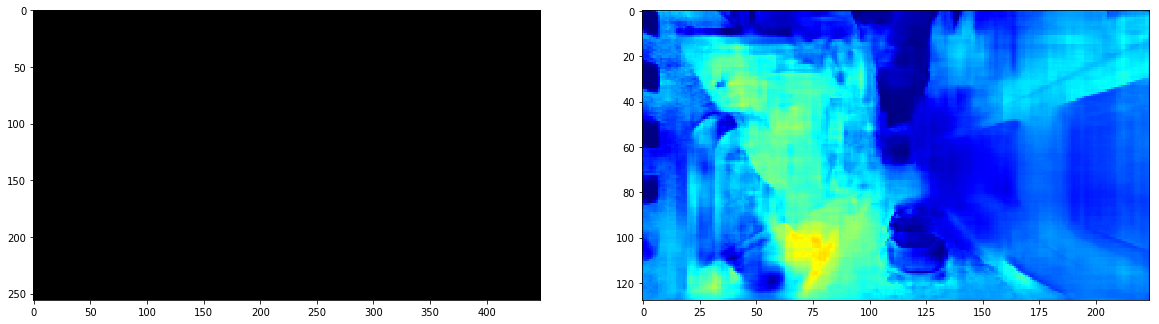

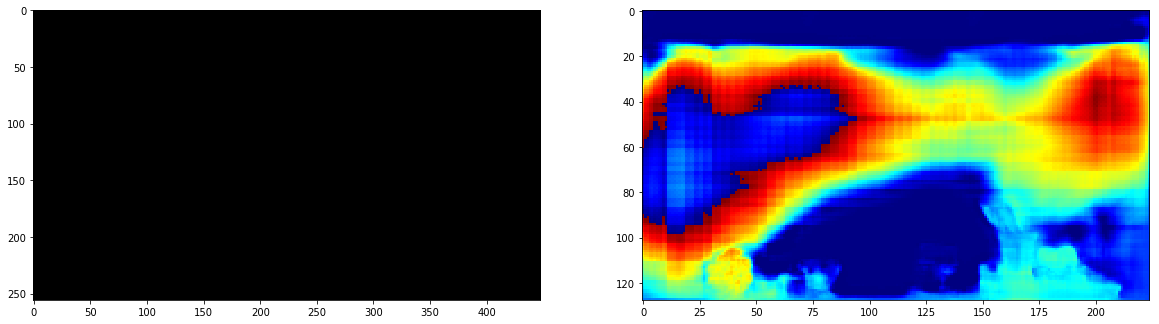

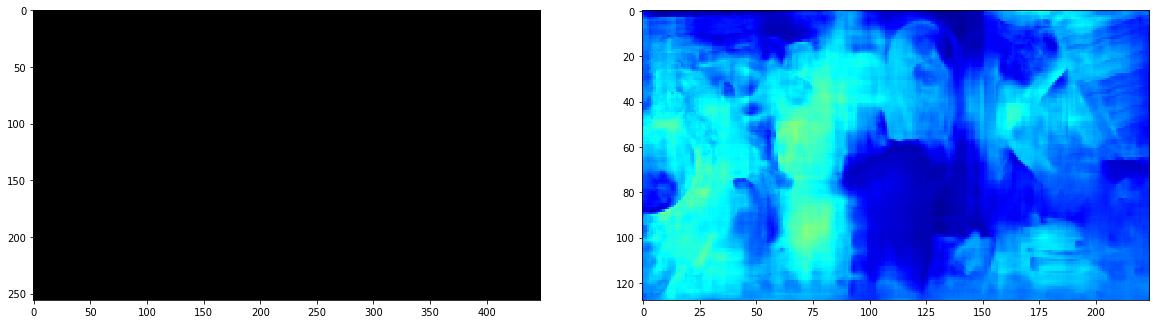

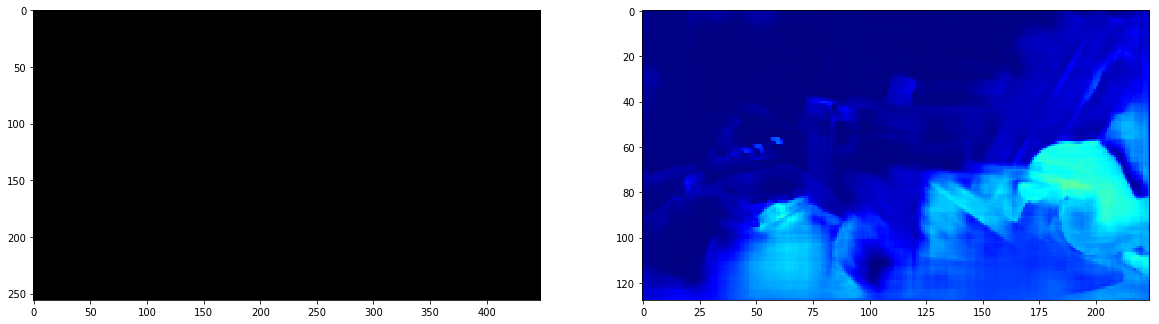

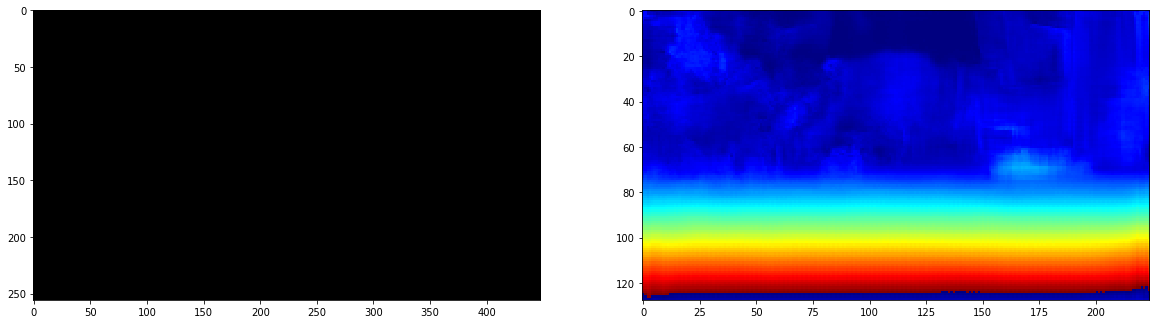

10620/10619 [==============================] - 9698s 913ms/step - loss: 22.3706 - val_loss: 13.5296
Epoch 2/160
 4258/10619 [===========>..................] - ETA: 1:20:15 - loss: 14.0134

KeyboardInterrupt: 

In [5]:
csv_logger = CSVLogger('./checkpoints/DispNetCorr_training_log.csv', append=True, separator=';')
TensorBoard = tf.contrib.keras.callbacks.TensorBoard(
    log_dir="TensorBoard/DispNetTensorBoard/DispNetCorr/",
    histogram_freq = 0,
    write_graph=True, 
    write_images=True)
class batchtime(Callback):
    def __init__(self):
        self.start_time = 0
        self.end_time = 0
        
    def on_batch_begin(self, batch, logs={}):
        self.start_time = timeit.default_timer()

    def on_batch_end(self, batch, logs={}):
        self.end_time = timeit.default_timer()
        clear_output()
        print('batch_step_time = %.3f' % (self.end_time - self.start_time))
        
class WeightsSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.epoch = 1

    def on_epoch_end(self, epoch, logs={}):
        #'''
        if self.epoch % self.N == 0:
            self.model.save_weights('./checkpoints/dispnetCorr(%dth).hdf5' % self.epoch)
            if not os.path.exists('./test_set/DispNetCorr_test/'):
                os.makedirs('./test_set/DispNetCorr_test/')
            test_paths = ['CG_Testset1_20180711', 'ETRI_chef_0_100', 'TechnicolorPainter_pr_100_#00_#15', 'middleburry', 'Sceneflow']
            clear_output()
            print('DispNetCorr_test of %dth epoch' % self.epoch)
            for test_path in test_paths:
                path = './test_set/' + test_path
                left_image = cv2.imread((path + '/Image_00.png').replace("Scene Flow Datasets", "resized_SFD"), cv2.IMREAD_COLOR)
                left_image_=cv2.resize(left_image, (model.model_in_width, model.model_in_height),cv2.INTER_CUBIC)
                right_image = cv2.imread((path + '/Image_01.png').replace("left", "right").replace("Scene Flow Datasets", "resized_SFD"), cv2.IMREAD_COLOR) 
                right_image_=cv2.resize(left_image, (model.model_in_width, model.model_in_height),cv2.INTER_CUBIC)
                prediction = self.model.predict([left_image_[np.newaxis,:], right_image_[np.newaxis,:]], batch_size=1)
                fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
                ax0.imshow(np.zeros((256, 448, 3)), cmap = 'summer')
                if os.path.exists(path + 'Disp_00.pfm'):
                    ground_truth = dataset.read_pfm(fpath = path + 'Disp_00.pfm')
                    ground_truth_img = cv2.applyColorMap(ground_truth, cv2.COLORMAP_SUMMER)
                    b, g, r = cv2.split(ground_truth_img)
                    image2 =cv2.merge([r,g,b])
                    ax0.imshow(image2, cmap = 'summer')
                if not os.path.exists('./test_set/DispNetCorr_test/%dth_epoch/' % self.epoch):
                    os.makedirs('./test_set/DispNetCorr_test/%dth_epoch/' % self.epoch)
                prediction_img = cv2.applyColorMap(prediction[0,:].astype(np.uint8), cv2.COLORMAP_JET)
                b, g, r = cv2.split(prediction_img)
                image2 =cv2.merge([r,g,b])
                ax1.imshow(image2, cmap = 'summer')
                plt.show()
                save_path = './test_set/DispNetCorr_test/%dth_epoch/' % self.epoch
                cv2.imwrite(save_path + test_path + '.png', prediction_img)
                np.save(save_path + test_path + '.npy', prediction[0,:])
            self.epoch += 1
        #'''

def trainDataGenerator(data_paths, target_input_size = (model.model_in_width, model.model_in_height), 
                       target_output_size = (model.model_out_height, model.model_out_width), batch_size = 1):
    train_left_inputBatch = []
    train_right_inputBatch = []
    train_left_groundTruthBatch = []
    #train_left_groundTruthBatch2 = []
    #train_left_groundTruthBatch3 = []
    #train_left_groundTruthBatch4 = []
    #train_left_groundTruthBatch5 = []
    #train_left_groundTruthBatch6 = []
    while True:
        for dir_ in data_paths:
            tmp = cv2.imread(dir_, cv2.IMREAD_COLOR)
            l_img_nparray = cv2.resize(tmp, target_input_size, interpolation=cv2.INTER_CUBIC)

            tmp = cv2.imread(dir_.replace("left", "right"), cv2.IMREAD_COLOR)
            r_img_nparray = cv2.resize(tmp, target_input_size, interpolation=cv2.INTER_CUBIC)

            if 'driving__frames_cleanpass' in dir_:
                tmp = dir_.replace("driving__frames_cleanpass", "driving__disparity")
                dir_ = tmp.replace("frames_cleanpass", "disparity")
            elif 'driving__frames_finalpass' in dir_:
                tmp = dir_.replace("driving__frames_finalpass", "driving__disparity")
                dir_ = tmp.replace("frames_finalpass", "disparity")
            elif 'flyingthings3d__frames_cleanpass' in dir_:
                tmp = dir_.replace("flyingthings3d__frames_cleanpass", "flyingthings3d__disparity")
                dir_ = tmp.replace("frames_cleanpass", "disparity")
            elif 'flyingthings3d__frames_finalpass' in dir_:
                tmp = dir_.replace("flyingthings3d__frames_finalpass", "flyingthings3d__disparity")
                dir_ = tmp.replace("frames_finalpass", "disparity")
            elif 'monkaa__frames_cleanpass' in dir_:
                tmp = dir_.replace("monkaa__frames_cleanpass", "monkaa__disparity")
                dir_ = tmp.replace("frames_cleanpass", "disparity")
            elif 'monkaa__frames_finalpass' in dir_:
                tmp = dir_.replace("monkaa__frames_finalpass", "monkaa__disparity")
                dir_ = tmp.replace("frames_finalpass", "disparity")

            ground_truth = cv2.resize(dataset.read_pfm(dir_.replace(".png", ".pfm")), (model.model_out_width, model.model_out_height), interpolation=cv2.INTER_CUBIC)
            #ground_truth2 = cv2.resize(dataset.read_pfm(dir_.replace(".png", ".pfm")), (int(model.model_out_width/2), int(model.model_out_height/2)), interpolation=cv2.INTER_CUBIC)
            #ground_truth3 = cv2.resize(dataset.read_pfm(dir_.replace(".png", ".pfm")), (int(model.model_out_width/4), int(model.model_out_height/4)), interpolation=cv2.INTER_CUBIC)
            #ground_truth4 = cv2.resize(dataset.read_pfm(dir_.replace(".png", ".pfm")), (int(model.model_out_width/8), int(model.model_out_height/8)), interpolation=cv2.INTER_CUBIC)
            #ground_truth5 = cv2.resize(dataset.read_pfm(dir_.replace(".png", ".pfm")), (int(model.model_out_width/16), int(model.model_out_height/16)), interpolation=cv2.INTER_CUBIC)
            #ground_truth6 = cv2.resize(dataset.read_pfm(dir_.replace(".png", ".pfm")), (int(model.model_out_width/32), int(model.model_out_height/32)), interpolation=cv2.INTER_CUBIC)

            train_left_inputBatch += [l_img_nparray]
            train_right_inputBatch += [r_img_nparray]
            train_left_groundTruthBatch += [ground_truth[:,:,np.newaxis]]
            #train_left_groundTruthBatch2 += [ground_truth2[:,:,np.newaxis]]
            #train_left_groundTruthBatch3 += [ground_truth3[:,:,np.newaxis]]
            #train_left_groundTruthBatch4 += [ground_truth4[:,:,np.newaxis]]
            #train_left_groundTruthBatch5 += [ground_truth5[:,:,np.newaxis]]
            #train_left_groundTruthBatch6 += [ground_truth6[:,:,np.newaxis]]

            if len(train_left_groundTruthBatch) == batch_size:
                batch_input_x = [np.array(train_left_inputBatch), np.array(train_right_inputBatch)]
                batch_input_y = [np.array(train_left_groundTruthBatch)]
                '''
                batch_input_y = [np.array(train_left_groundTruthBatch), np.array(train_left_groundTruthBatch2), 
                                 np.array(train_left_groundTruthBatch3), np.array(train_left_groundTruthBatch4), 
                                 np.array(train_left_groundTruthBatch5), np.array(train_left_groundTruthBatch6)]
                #'''
                train_left_inputBatch = []
                train_right_inputBatch = []
                train_left_groundTruthBatch = []
                #train_left_groundTruthBatch2 = []
                #train_left_groundTruthBatch3 = []
                #train_left_groundTruthBatch4 = []
                #train_left_groundTruthBatch5 = []
                #train_left_groundTruthBatch6 = []

                yield (batch_input_x, batch_input_y)

directories = [i for i in dataset.data_paths if ('left' in i) and ('.png' in i)]
shuffle(directories)

train_paths = directories[0:int(len(directories)*t_v_data_rate)]
train_generator = trainDataGenerator(data_paths = train_paths, batch_size = train_batch_size)

validation_paths = directories[int(len(directories)*t_v_data_rate):]
validation_generator = trainDataGenerator(data_paths = validation_paths, batch_size = train_batch_size)

net.fit_generator(train_generator,
                  epochs = 160,
                  steps_per_epoch = len(train_paths)/train_batch_size,
                  validation_data = validation_generator,
                  validation_steps = len(validation_paths)/train_batch_size,
                  verbose = 1,
                  callbacks=[TensorBoard, csv_logger, WeightsSaver(1)])

In [ ]:
'''
directories = [i for i in dataset.data_paths if ('left' in i) and ('.png' in i)]
shuffle(directories)

t_v_data_rate = 0.8
train_batch_size = 2
train_paths = directories[0:int(len(directories)*t_v_data_rate)]
train_generator = trainDataGenerator(data_paths = train_paths, batch_size = train_batch_size)

validation_paths = directories[int(len(directories)*t_v_data_rate):]
validation_generator = trainDataGenerator(data_paths = validation_paths, batch_size = train_batch_size)

net.fit_generator(train_generator,
                  epochs = 100,
                  steps_per_epoch = len(train_paths)/train_batch_size,
                  validation_data = validation_generator,
                  validation_steps = len(validation_paths)/train_batch_size,
                  use_multiprocessing=False
                  callbacks=[TensorBoard, csv_logger, WeightsSaver(1)])
'''

In [ ]:
net.save_weights('./checkpoints/dispnetCorr.hdf5')